In [1]:
!pip install imbalanced-learn --quiet

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt


In [2]:
# Load all MIMIC datasets
patients = pd.read_csv('/content/PATIENTS.csv')
admissions = pd.read_csv('/content/ADMISSIONS.csv')
diagnoses_icd = pd.read_csv('/content/DIAGNOSES_ICD.csv')
labevents = pd.read_csv('/content/LABEVENTS.csv')
chartevents = pd.read_csv('/content/CHARTEVENTS.csv', low_memory=False)
noteevents = pd.read_csv('/content/NOTEEVENTS.csv')

# Load external datasets
framingham = pd.read_csv('/content/framingham.csv')
cleveland_heart = pd.read_csv('/content/cleveland_heart_disease.csv')


In [3]:
# Fill NaNs
framingham.fillna(framingham.mean(), inplace=True)
cleveland_heart.fillna(cleveland_heart.mean(), inplace=True)
patients.fillna("Unknown", inplace=True)
admissions.fillna("Unknown", inplace=True)
diagnoses_icd.fillna("Unknown", inplace=True)
labevents.fillna(0, inplace=True)
chartevents.fillna(0, inplace=True)
noteevents.fillna("Unknown", inplace=True)

# Encode categorical variables
label_encoder = LabelEncoder()
patients['gender'] = label_encoder.fit_transform(patients['gender'])
framingham['sex'] = label_encoder.fit_transform(framingham['sex'])
cleveland_heart['sex'] = label_encoder.fit_transform(cleveland_heart['sex'])


In [4]:
# Aggregate LABEVENTS
lab_summary = labevents.groupby('subject_id')['valuenum'].agg(['mean', 'std', 'min', 'max']).reset_index()
lab_summary.columns = ['subject_id', 'lab_mean', 'lab_std', 'lab_min', 'lab_max']

# Aggregate CHARTEVENTS (e.g., vitals like heart rate)
chart_summary = chartevents.groupby('subject_id')['valuenum'].agg(['mean', 'std']).reset_index()
chart_summary.columns = ['subject_id', 'chart_mean', 'chart_std']


In [5]:
# Merge MIMIC datasets
mimic_data = pd.merge(patients, admissions, on='subject_id', how='left')
mimic_data = pd.merge(mimic_data, diagnoses_icd, on='subject_id', how='left')
mimic_data = pd.merge(mimic_data, lab_summary, on='subject_id', how='left')
mimic_data = pd.merge(mimic_data, chart_summary, on='subject_id', how='left')
mimic_data.fillna(0, inplace=True)

# Add a dummy binary target for example (replace with real condition if you have one)
mimic_data['target'] = mimic_data['diagnosis'].apply(lambda x: 1 if 'heart' in str(x).lower() else 0)


In [6]:
# Merge MIMIC data
merged_mimic = pd.merge(patients, diagnoses_icd, on='subject_id', how='left')
merged_mimic = pd.merge(merged_mimic, lab_summary, on='subject_id', how='left')
merged_mimic.fillna(0, inplace=True)

# Combine all data
merged_data = pd.concat([merged_mimic, framingham, cleveland_heart], axis=0)
merged_data['target'] = merged_data['target'].fillna(merged_data['target'].mode()[0])

# Prepare features and labels
X = merged_data.drop(columns=['target'])
X = X.select_dtypes(include=[np.number]).fillna(0)
y = merged_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [7]:
results = []

def evaluate_model(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'AUC-ROC': auc_roc
    })

    print(f"\n{model_name} - Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(f'AUC-ROC Curve for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Logistic Regression - Evaluation Metrics:
Accuracy: 0.9921
Precision: 0.9952
Recall: 0.9968
AUC-ROC: 0.8800
Confusion Matrix:
[[  29    9]
 [   6 1848]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.76      0.79        38
         1.0       1.00      1.00      1.00      1854

    accuracy                           0.99      1892
   macro avg       0.91      0.88      0.90      1892
weighted avg       0.99      0.99      0.99      1892



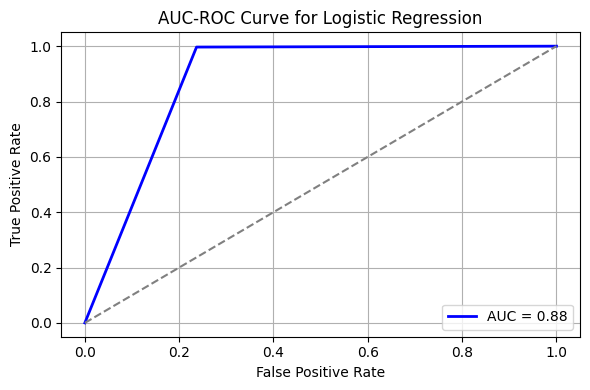


Random Forest - Evaluation Metrics:
Accuracy: 0.9900
Precision: 0.9951
Recall: 0.9946
AUC-ROC: 0.8789
Confusion Matrix:
[[  29    9]
 [  10 1844]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75        38
         1.0       1.00      0.99      0.99      1854

    accuracy                           0.99      1892
   macro avg       0.87      0.88      0.87      1892
weighted avg       0.99      0.99      0.99      1892



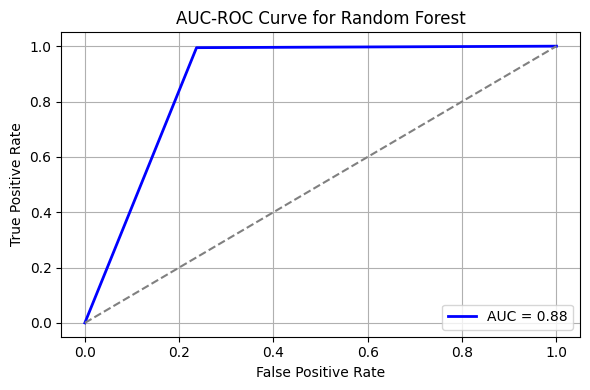

In [8]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
evaluate_model(y_test, log_reg.predict(X_test), "Logistic Regression")

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
evaluate_model(y_test, rf.predict(X_test), "Random Forest")



🔹 Option 2: LinearSVC (Super Fast)

Linear SVM - Evaluation Metrics:
Accuracy: 0.9820
Precision: 0.9908
Recall: 0.9908
AUC-ROC: 0.7717
Confusion Matrix:
[[  21   17]
 [  17 1837]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.55      0.55        38
         1.0       0.99      0.99      0.99      1854

    accuracy                           0.98      1892
   macro avg       0.77      0.77      0.77      1892
weighted avg       0.98      0.98      0.98      1892



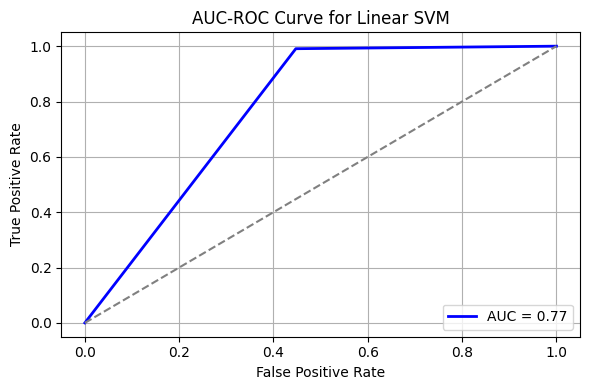


Tuned Neural Network - Evaluation Metrics:
Accuracy: 0.9847
Precision: 0.9856
Recall: 0.9989
AUC-ROC: 0.6442
Confusion Matrix:
[[  11   27]
 [   2 1852]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.29      0.43        38
         1.0       0.99      1.00      0.99      1854

    accuracy                           0.98      1892
   macro avg       0.92      0.64      0.71      1892
weighted avg       0.98      0.98      0.98      1892



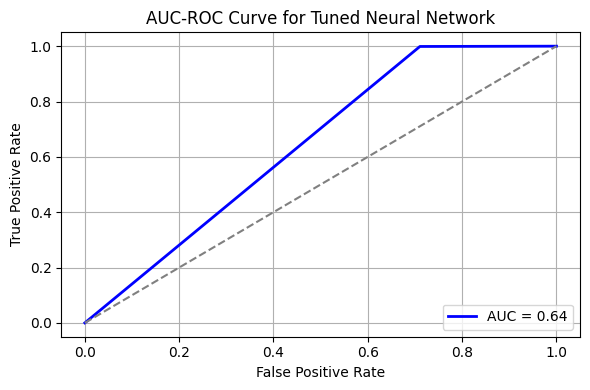

In [17]:
#===============================
# 🔹 OPTION 2: Linear SVM (Fastest)
# ===============================

print("\n🔹 Option 2: LinearSVC (Super Fast)")

linear_svm = LinearSVC(max_iter=1000)
linear_svm.fit(X_train, y_train)
evaluate_model(y_test, linear_svm.predict(X_test), "Linear SVM")


# Neural Network with Grid Search
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}
mlp_grid = GridSearchCV(MLPClassifier(max_iter=1000, random_state=42), mlp_params, scoring='recall', cv=3, n_jobs=-1)
mlp_grid.fit(X_train, y_train)
evaluate_model(y_test, mlp_grid.predict(X_test), "Tuned Neural Network")


In [18]:
# Cross-validation for final model (Random Forest as example)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X, y, cv=cv, scoring='roc_auc')
print(f"\nRandom Forest Cross-Validated AUC-ROC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Summary of all model results
print("\nModel Comparison Summary:")
pd.DataFrame(results).sort_values(by='Recall', ascending=False)



Random Forest Cross-Validated AUC-ROC: 0.9974 ± 0.0013

Model Comparison Summary:


,Model,Accuracy,Precision,Recall,AUC-ROC
4,Tuned SVM (Downsampled),0.979915,0.979915,1.000000,0.500000
3,Tuned Neural Network,0.984672,0.985631,0.998921,0.644197
5,Tuned Neural Network,0.984672,0.985631,0.998921,0.644197
7,Tuned Neural Network,0.984672,0.985631,0.998921,0.644197
0,Logistic Regression,0.992072,0.995153,0.996764,0.879961
2,Randomized SVM,0.975687,0.979830,0.995685,0.497843
1,Random Forest,0.989958,0.995143,0.994606,0.878882
6,Linear SVM,0.982030,0.990831,0.990831,0.771731


from matplotlib import pyplot as plt
_df_0['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['AUC-ROC'].plot(kind='hist', bins=20, title='AUC-ROC')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Accuracy', y='Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Recall', y='AUC-ROC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['AUC-ROC'].plot(kind='line', figsize=(8, 4), title='AUC-ROC')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='Precision', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='Recall', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='AUC-ROC', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_16['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_20.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21.plot(kind='scatter', x='index', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='Accuracy', y='Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_24.plot(kind='scatter', x='Recall', y='AUC-ROC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_25['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_26['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_27['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_28['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_29['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_29, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_30['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_30, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_31['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_31, x='Precision', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_32['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_32, x='Recall', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-21-16ecc6618585>:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


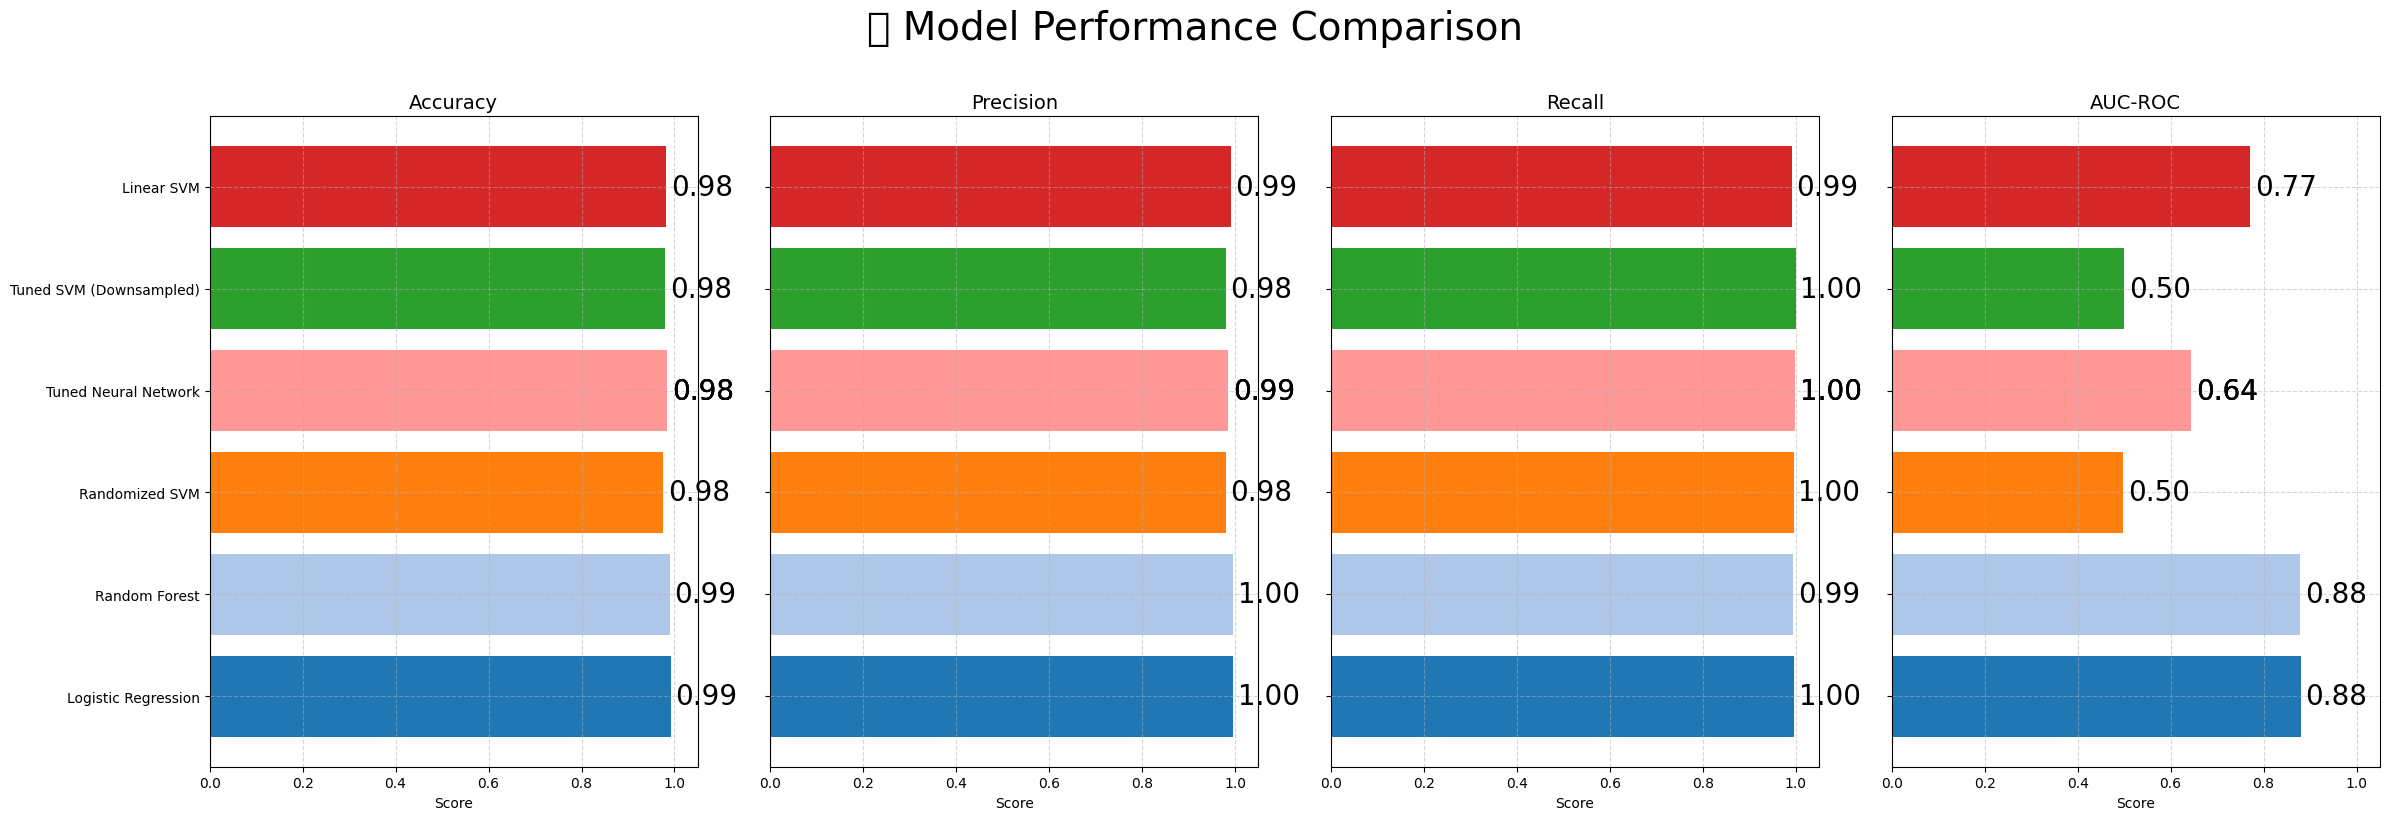

In [21]:
# Convert results list to a DataFrame
results_df = pd.DataFrame(results)

# Define colors for each model (loop-safe)
color_palette = plt.cm.tab20.colors  # Up to 20 distinct colors
model_colors = {model: color_palette[i % len(color_palette)] for i, model in enumerate(results_df['Model'])}

# Plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'AUC-ROC']
fig, axes = plt.subplots(1, len(metrics), figsize=(24, 8), sharey=True)

for i, metric in enumerate(metrics):
    bars = axes[i].barh(
        results_df['Model'],
        results_df[metric],
        color=[model_colors[model] for model in results_df['Model']]
    )
    axes[i].set_title(f'{metric}', fontsize=14)
    axes[i].set_xlabel('Score')
    axes[i].set_xlim(0, 1.05)
    axes[i].grid(True, linestyle='--', alpha=0.5)

    # Add score text on bars
    for bar in bars:
        width = bar.get_width()
        axes[i].text(width + 0.01, bar.get_y() + bar.get_height()/2,
                     f'{width:.2f}', va='center', fontsize=20)

# Overall title
plt.suptitle('📊 Model Performance Comparison', fontsize=28, y=1.02)
plt.tight_layout()
plt.show()
